exploration3 had confusingly interleaved two separate appraoches. Here we focus on just one, cleaned up quite a bit.

We are using phoible to map ipa segments to feature vectors, and then attempting to learn a linear operator on feature space that makes the closeness of feature vectors correspond to the tendency for those segments to be allophones.

In [4]:
%matplotlib inline

import numpy as np
import torch
import matplotlib.pyplot as plt

In [5]:
import torch.nn as nn

class EmbedPhones(nn.Module):

    def __init__(self, num_features):
        super(EmbedPhones, self).__init__()
        
        self.res = nn.Linear(num_features,num_features,bias=False)
#         identity=torch.from_numpy(np.identity(num_features,dtype=np.dtype('float32')))
        with torch.no_grad():
            self.res.weight.normal_(0,0.02)
#             self.embed.weight += identity
        
    def forward(self, x):
        
        return x+self.res(x) # res represents the difference between the embedding map and the identity map


In [25]:
import os,sys
def add_path_to_local_module(module_name):
    module_path = os.path.abspath(os.path.join(module_name))
    if module_path not in sys.path:
        sys.path.append(module_path)
add_path_to_local_module("epitran")
add_path_to_local_module("panphon")

import panphon.featuretable
ft = panphon.featuretable.FeatureTable()

from wordgen import *
wg = WordgenLearned(3,"ind-Latn")

Loading Epitran with language code ind-Latn... success!


In [7]:
class SuppressedMessenger(object):
    """ A class to output messages with output being supressed at a certain point."""
    def __init__(self,name,max_messages):
        self.name = name
        self.num_printed = 0
        self.max_messages = max_messages
        self.stopped_printing = False if max_messages > 0 else True

    def print(self,msg):
        if self.num_printed < self.max_messages:
            print(msg)
            self.num_printed += 1
        elif not self.stopped_printing:
            print("[Further output regarding "+self.name+" will be suppressed]")
            self.stopped_printing = True

In [8]:
import csv

feat_vals = {'+':1,'-':-1,'0':0}

to_phoible_feats_dict = {}

f = open('phoible.csv')
reader = csv.reader(f)
head = next(reader)
phoneme_index = head.index('Phoneme')
langkey_index = head.index('ISO6393')
first_feat_index = head.index('tone')
last_feat_index = head.index('click')
skipped_msg = SuppressedMessenger("bad feature labels", 10)
contradiction_msg = SuppressedMessenger("phoible contradictions", 30)
print("Building mapping from phoible phonemes to feature space...")
for i,row in enumerate(reader):
    phoneme = row[phoneme_index]
    raw_feats = row[first_feat_index:last_feat_index+1]
#     if any(len(feat)>1 for feat in raw_feats):
#         skipped_msg.print("Skipping phoneme "+phoneme+": multiple feature labels")
    #Instead lets add together multiple feature labels
    
    try:
        feats = np.array([sum(feat_vals[v] for v in val.split(',')) for val in raw_feats],dtype=np.dtype('float32'))
    except KeyError:
        skipped_msg.print("Skipping phoneme "+phoneme+": weird feature label")
    if phoneme in to_phoible_feats_dict.keys():
        if not np.array_equal(feats,to_phoible_feats_dict[phoneme]):
            contradiction_msg.print("Phoible contradiction for phoneme "+phoneme+"; language "+row[langkey_index]+" conflicts w/ prev entry")
    else:
        to_phoible_feats_dict[phoneme] = feats
f.close()

Building mapping from phoible phonemes to feature space...
Skipping phoneme ɹ̪̹̩: weird feature label
Skipping phoneme ɻ̹̩: weird feature label
Skipping phoneme ɹ̪̹̩: weird feature label


In [9]:
num_features = len(to_phoible_feats_dict['a'])
len(to_phoible_feats_dict),num_features

(3183, 37)

In [10]:
# will need to convert some ipa segs produced by epitran into the representation in phoible
epitran_to_phoible_replacements = {
    'd͡ʒ':'d̠ʒ',
    't͡ʃ':'t̠ʃ',
    't͡ɕ':'tɕ',
    't͡s':'ts',
    'd͡ʑ':'dʑ',
}

def epitran_to_phoible(epitran_ipa):
    phoible_ipa = epitran_ipa
    for a,b in epitran_to_phoible_replacements.items():
        phoible_ipa = phoible_ipa.replace(a,b)
    return phoible_ipa

In [15]:
class NoPhoibleFeatures(Exception):
    pass
class NoAvailableData(Exception):
    pass

def to_phoible_fts(ipa_symbols):
    """ Convert a string of ipa symbols to a torch matrix whose rows are features.
        Do not include duplicates when panphon identifies symbols in terms of features. """
    if ipa_symbols == "NA" :  raise NoAvailableData("The string you gave indicates that there's no allophone data")
    fts=[]
    for ft in ipa_symbols.split():
        ft = epitran_to_phoible(ft)
        try:
            fts.append(to_phoible_feats_dict[ft])
        except KeyError:
            continue
    if not fts:
        raise NoPhoibleFeatures("All the phonemes in '"+ipa_symbols+"' are giving trouble")
    fts = np.array(fts) 
    fts = np.unique(fts,axis=0) # do not allow duplicates. TODO: actually you should raise error if you see duplicates; it's not supposed to happen with phoible
    fts = fts.astype(np.dtype('float32')) # this is not needed i think, dtype was already set
    return torch.from_numpy(fts)

In [16]:
import csv

def allophone_data_by_language(num_lists=np.inf):
    f = open('phoible.csv')
    reader = csv.reader(f)
    head = next(reader)
    allophones_index = head.index('Allophones')
    langkey_index = head.index('ISO6393')
    last_langkey = "not a lang key"
    num_yielded = 0
    for i,row in enumerate(reader):
        if row[langkey_index] != last_langkey:
#             print("About to yield data for language",last_langkey)
            last_langkey = row[langkey_index]
            if i!=0 and allophone_data:
                yield allophone_data
                num_yielded += 1
            if num_yielded >= num_lists: break
            allophone_data = []
        try:
            allophone_list = to_phoible_fts(row[allophones_index])
        except NoAvailableData: # We will just skip the entire list of allophones in this case
            continue
        allophone_data.append(allophone_list)
    f.close()

In [17]:
allophone_data_by_language_list = list(allophone_data_by_language())

In [18]:
import random

def allophone_data_by_language_shuffled():
    indices = list(range(len(allophone_data_by_language_list)))
    random.shuffle(indices)
    for index in indices:
        yield allophone_data_by_language_list[index]

In [28]:
def distinct_pairs(N):
    """Generate pairs of integers i<j such that 0 <= i < j < N"""
    for i in range(N):
        for j in range(i+1,N):
            yield i,j
            
def sqdist(x,y):
    """Return squared distance between two 1D torch tensors"""
    return ((x-y)**2).sum()

def dist(x,y):
    """distance between two feature vectors (1d torch tensors) after embedding"""
    return torch.sqrt(sqdist(emb(x),emb(y))).item()

In [20]:
import torch.optim as optim

In [39]:
emb = EmbedPhones(num_features)
lr = 0.00001
alpha = 0.01
lambda_ = 1.
epochs = 10
optimizer = optim.Adam(emb.parameters(),lr=lr,weight_decay=lambda_)

costs = []
costs_plot = []
for e in range(epochs):
    for step_num,allophone_data in enumerate(allophone_data_by_language_shuffled()):

        allophone_dists   = 0.
        nallophone_dists  = 0. 

        optimizer.zero_grad()

        for allophone_list in allophone_data:
            for i,j in distinct_pairs(len(allophone_list)):
                allophone_dists += sqdist(emb(allophone_list[i]),emb(allophone_list[j]))
        for i,j in distinct_pairs(len(allophone_data)):
            for x in allophone_data[i]:
                for y in allophone_data[j]:
                    nallophone_dists += sqdist(emb(x),emb(y))

        cost = allophone_dists - alpha * nallophone_dists
        cost.backward()
        costs.append(cost.item())
        if step_num%10==0:
            costs_plot.append(np.mean(costs))
            sys.stdout.write("Epoch "+str(e)+", "+str(step_num)+" languages processed. Avg cost: "+str(np.mean(costs))+"               \r")
            sys.stdout.flush()
            costs = []
        optimizer.step()

In [40]:
emb.res.weight

Parameter containing:
tensor([[ 0.0455,  0.0232, -0.0622,  ...,  0.0368,  0.0590, -0.0338],
        [ 0.0419,  0.0607, -0.0688,  ...,  0.0085,  0.0204, -0.0255],
        [-0.0051,  0.0245,  0.0539,  ..., -0.0022,  0.0034,  0.0392],
        ...,
        [ 0.0566,  0.0329, -0.0225,  ...,  0.0746, -0.0061,  0.0061],
        [ 0.0035,  0.0181, -0.0818,  ...,  0.0216,  0.0135, -0.0423],
        [ 0.0416, -0.0016,  0.0767,  ...,  0.0408,  0.0717,  0.0507]],
       requires_grad=True)

In [41]:
ipa_charsets = ['eng-Latn','ind-Latn','ita-Latn','kaz-Cyrl','orm-Latn','pan-Guru']
ipa_chars = set()
for ipa_charset in ipa_charsets:
    ipa_chars = ipa_chars.union(wg.load_ipa_chars(ipa_charset))
ipa_chars.remove('ː')
ipa_chars.remove('̃')
ipa_chars = list(ipa_chars)
num_chars = len(ipa_chars)
print(num_chars,ipa_chars)

107 ['o', 'pʰ', 'ʃ', 'kʼː', 'tː', 't', 'u', 'd͡ʒː', 'æ', 'tʼ', 'i̯', 'ᶑ', 'ɡ', 'ʈʰ', 'ɛ', 'ɣ', 'ɖ', 'ɹ̩', 'd', 'z', 'n̩', 'ɥ', 't͡s', 'd̪', 'l', 'm', 'd͡ʒ', 'kʼ', 'ʋ', 'θ', 'ɲ', 'kʰ', 'f', 'ɡː', 'iː', 'ʊ', 'fː', 'eː', 'j', 'ʒ', 't͡ʃʼː', 'ɭ', 'lː', 'h', 'ð', 't͡ʃʰ', 'n', 'pʼ', 'ɹ', 'hː', 'pː', 't͡ʃʼ', 'ʌ', 'vː', 'i', 'ʉ', 'ɪ', 'm̩', 'sː', 'kː', 'ɳ', 'uː', 'd͡ʑ', 'ŋ', 't͡ɕ', 'q', 'dː', 'e', 'ɑ', 's', 'k', 'a', 'b', 'pʼː', 'ʃː', 'ɦ', 'ə', 'ɕː', 'zː', 'ʎ', 'ɔ', 'tʼː', 'ɘ', 'wː', 'bː', 't̪', 't̪ʰ', 'ɾ', 'oː', 'p', 'v', 'w', 'nː', 'rː', 'jː', 'mː', 'ɲː', 't͡ʃː', 'ɽ', 'ɕ', 'ʁ', 'x', 'aː', 't͡ʃ', 'ʈ', 'r', 'ʔ']



alpha = 0.01


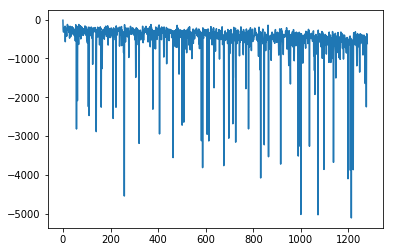

14.763212203979492 2.062192440032959


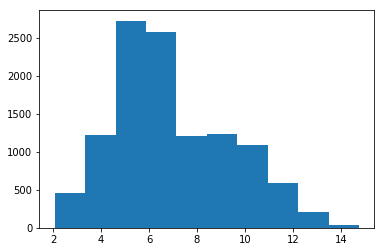

In [42]:
dists = []
for c1 in ipa_chars:
    for c2 in ipa_chars:
        s1,s2 = to_phoible_fts(c1),to_phoible_fts(c2)
        assert(len(s1)==1)
        assert(len(s2)==1)
        s1,s2 = s1[0],s2[0]
        if c1 != c2 : dists.append(dist(s1,s2))
max_dist,min_dist = max(dists),min(dists)
print("\nalpha =",alpha)
plt.plot(costs_plot)
plt.show()
print(max_dist,min_dist)
plt.hist(dists)
plt.show()

In [55]:
projection = [n for n in range(num_chars)] # we start with identity mapping and will gradually identify things
# think of projection as mapping from indices representing ipa_chars to equivalence classes
# the number of equivalence classes is len(set(projection))
M = 40
step_size = (max_dist-min_dist)/float((len(ipa_chars)-M)*500)
spread = (max_dist-min_dist)/20.
for r0 in np.arange(min_dist,max_dist,step_size):
    r = max(step_size,np.random.normal(r0,spread))
    ipa_char_index = np.random.randint(num_chars)
    s0 = to_phoible_fts(ipa_chars[ipa_char_index])
    assert(len(s0)==1)
    s0 = s0[0]
    for n in range(num_chars):
        s = to_phoible_fts(ipa_chars[n])
        assert(len(s)==1)
        s = s[0]
        if dist(s,s0)<r:
            projection[n]=projection[ipa_char_index]
    if len(set(projection))<=M: break
        
for p in set(projection):
    print([ipa_chars[n] for n in range(num_chars) if projection[n]==p])

['kʼː']
['tː', 'ᶑ', 'ɖ', 'd', 'd̪', 'dː', 'ʈ']
['ʈʰ']
['ɹ̩']
['ɥ']
['z', 't͡s', 'θ', 'sː', 's']
['l', 'ɭ', 'lː', 'ɽ']
['kʼ']
['ʋ']
['ɲ', 'ɲː']
['ɡ', 'kʰ', 'ɡː', 'kː', 'k']
['j', 'jː']
['t͡ʃʰ', 't͡ʃ']
['n̩', 'n', 'ɳ', 'nː']
['ɹ']
['hː']
['t͡ʃʼː', 't͡ʃʼ']
['f', 'fː', 'vː', 'v']
['ð', 'd͡ʑ', 't͡ɕ']
['ŋ']
['q']
['æ', 'i̯', 'ɛ', 'iː', 'eː', 'i', 'ɪ', 'e', 'a', 'ə', 'ɘ']
['ʌ', 'ɑ', 'aː']
['pʼ', 'pʼː']
['ʃ', 'd͡ʒː', 'd͡ʒ', 'ʒ', 'ʃː', 't͡ʃː']
['h', 'ɦ']
['ɕː', 'ɕ']
['zː']
['ʎ']
['tʼ', 'tʼː']
['wː', 'w']
['t', 't̪', 't̪ʰ']
['o', 'u', 'ʊ', 'ʉ', 'uː', 'ɔ', 'oː']
['pʰ', 'pː', 'b', 'bː', 'p']
['rː']
['m', 'm̩', 'mː']
['ɾ']
['ɣ', 'ʁ', 'x']
['r']
['ʔ']


Okay let's assume this works and look into the problem of choosing a representative from each equivalence class.

Initital idea: Choose a random direction in feature space (post-emb feature space, I think), and always pick the representative that is most in that direction

In [119]:
direction = np.array([np.random.normal() for _ in range(num_features)])

In [120]:
section = {} # Think of section as a map back from the codomain of projection to the domain which picks a rep of each equivalence class
for p in set(projection):
    equiv_class = [n for n in range(num_chars) if projection[n]==p]
    rep = max(equiv_class,key=lambda n : np.dot(to_phoible_fts(ipa_chars[n]).numpy(),direction).item())
    for n in equiv_class: section[n] = rep
    print(ipa_chars[rep],[ipa_chars[n] for n in equiv_class])

kʼː ['kʼː']
ɖ ['tː', 'ᶑ', 'ɖ', 'd', 'd̪', 'dː', 'ʈ']
ʈʰ ['ʈʰ']
ɹ̩ ['ɹ̩']
ɥ ['ɥ']
t͡s ['z', 't͡s', 'θ', 'sː', 's']
ɽ ['l', 'ɭ', 'lː', 'ɽ']
kʼ ['kʼ']
ʋ ['ʋ']
ɲ ['ɲ', 'ɲː']
ɡ ['ɡ', 'kʰ', 'ɡː', 'kː', 'k']
j ['j', 'jː']
t͡ʃ ['t͡ʃʰ', 't͡ʃ']
n̩ ['n̩', 'n', 'ɳ', 'nː']
ɹ ['ɹ']
hː ['hː']
t͡ʃʼ ['t͡ʃʼː', 't͡ʃʼ']
v ['f', 'fː', 'vː', 'v']
ð ['ð', 'd͡ʑ', 't͡ɕ']
ŋ ['ŋ']
q ['q']
a ['æ', 'i̯', 'ɛ', 'iː', 'eː', 'i', 'ɪ', 'e', 'a', 'ə', 'ɘ']
aː ['ʌ', 'ɑ', 'aː']
pʼ ['pʼ', 'pʼː']
d͡ʒ ['ʃ', 'd͡ʒː', 'd͡ʒ', 'ʒ', 'ʃː', 't͡ʃː']
ɦ ['h', 'ɦ']
ɕ ['ɕː', 'ɕ']
zː ['zː']
ʎ ['ʎ']
tʼ ['tʼ', 'tʼː']
w ['wː', 'w']
t ['t', 't̪', 't̪ʰ']
ʊ ['o', 'u', 'ʊ', 'ʉ', 'uː', 'ɔ', 'oː']
b ['pʰ', 'pː', 'b', 'bː', 'p']
rː ['rː']
m̩ ['m', 'm̩', 'mː']
ɾ ['ɾ']
ɣ ['ɣ', 'ʁ', 'x']
r ['r']
ʔ ['ʔ']


In [121]:
wg_eng = load_wg('en10e4.pkl')
wg_ind = load_wg('id10e5.pkl')

In [207]:
# These are the learned wordgen objects to be merged
learned_gens = [wg_eng,wg_ind]

# First gather all ipa_tokens
all_ipa_tokens = set()
for gen in learned_gens:
    all_ipa_tokens.update(gen.get_ipa_tokens())
    
# Remove any bad tokens that phoible won't like for the next part. If these are there then they're dumb anyway.
# We will also remove the start and end tokens; they will be brought back in later
bad_tokens = ['ː','̃','WORD_START','WORD_END']
for t in bad_tokens: 
    if t in all_ipa_tokens: 
        all_ipa_tokens.remove(t)
        
# Compute max and min distances tokens have from each other via the feature embedding
all_ipa_tokens = list(all_ipa_tokens)
num_all_tokens = len(all_ipa_tokens)
dists = []
for c1 in all_ipa_tokens:
    for c2 in all_ipa_tokens:
        s1,s2 = to_phoible_fts(c1),to_phoible_fts(c2)
        assert(len(s1)==1)
        assert(len(s2)==1)
        s1,s2 = s1[0],s2[0]
        if c1 != c2 : dists.append(dist(s1,s2))
max_dist,min_dist = max(dists),min(dists)

# Create equivalence classes of phonemes to cut down number of sounds
projection = [n for n in range(num_all_tokens)] # we start with identity mapping and will gradually identify things
# think of projection as mapping from indices representing ipa_chars to equivalence classes
# the number of equivalence classes is len(set(projection))
M = int(np.random.normal(35,10)) # choose number of sounds
step_size = (max_dist-min_dist)/float((num_all_tokens-M)*500)
spread = (max_dist-min_dist)/20.
for r0 in np.arange(min_dist,max_dist,step_size):
    r = max(step_size,np.random.normal(r0,spread))
    ipa_char_index = np.random.randint(num_all_tokens)
    s0 = to_phoible_fts(all_ipa_tokens[ipa_char_index])
    assert(len(s0)==1)
    s0 = s0[0]
    for n in range(num_all_tokens):
        s = to_phoible_fts(all_ipa_tokens[n])
        assert(len(s)==1)
        s = s[0]
        if dist(s,s0)<r:
            projection[n]=projection[ipa_char_index]
    if len(set(projection))<=M: break

# Choose a representative for each equivalence class to serve as the standard/official pronunciation for the new language
direction = np.array([np.random.normal() for _ in range(num_features)])
section = {} # Think of section as a map back from the codomain of projection to the domain which picks a rep of each equivalence class
for p in set(projection):
    equiv_class = [n for n in range(num_all_tokens) if projection[n]==p]
    rep = max(equiv_class,key=lambda n : np.dot(to_phoible_fts(all_ipa_tokens[n]).numpy(),direction).item())
    for n in equiv_class: section[n] = rep
    print(all_ipa_tokens[rep],[all_ipa_tokens[n] for n in equiv_class])

t͡ɕ ['t͡ɕ']
d͡ʒ ['ʃ', 't͡ʃ', 'd͡ʒ']
u ['o', 'u', 'ʊ']
i ['e', 'æ', 'ɛ', 'ə', 'i', 'ɪ']
ɑ ['ɑ', 'a']
ɡ ['k', 'ɡ']
s ['s']
d ['t', 'd']
n̩ ['n̩']
l ['l']
ɔ ['ɔ']
ɲ ['ɲ']
v ['f', 'v']
ɾ ['ɾ']
b ['b', 'p']
j ['j']
w ['w']
h ['h']
ʒ ['z', 'd͡ʑ', 'θ', 'ʒ', 'ð']
n ['n']
ɹ ['ɹ̩', 'ɹ']
ɕ ['ɕ']
ʌ ['ʌ']
x ['x']
m ['m', 'm̩']
ŋ ['ŋ']
r ['r']
ʔ ['ʔ']


In [220]:
# actually it will be more useful here to have a mapping from ipa tokens representing an equiv class to the rest of the equiv class
token_to_equivclass = {}
for rep_index in set(section.values()):
    equiv_class_indices = [n for n in range(num_all_tokens) if projection[n]==projection[rep_index]]
    equiv_class_tokens = [all_ipa_tokens[n] for n in equiv_class_indices]
    token_to_equivclass[all_ipa_tokens[rep_index]] = equiv_class_tokens
token_to_equivclass['WORD_START']=['WORD_START']
token_to_equivclass['WORD_END']=['WORD_END']
token_to_equivclass

{'t͡ɕ': ['t͡ɕ'],
 'u': ['o', 'u', 'ʊ'],
 'ɑ': ['ɑ', 'a'],
 'ɡ': ['k', 'ɡ'],
 'b': ['b', 'p'],
 's': ['s'],
 'd': ['t', 'd'],
 'n̩': ['n̩'],
 'l': ['l'],
 'ɔ': ['ɔ'],
 'm': ['m', 'm̩'],
 'd͡ʒ': ['ʃ', 't͡ʃ', 'd͡ʒ'],
 'ɲ': ['ɲ'],
 'ɾ': ['ɾ'],
 'v': ['f', 'v'],
 'j': ['j'],
 'w': ['w'],
 'ʒ': ['z', 'd͡ʑ', 'θ', 'ʒ', 'ð'],
 'h': ['h'],
 'n': ['n'],
 'ɹ': ['ɹ̩', 'ɹ'],
 'ɕ': ['ɕ'],
 'ʌ': ['ʌ'],
 'x': ['x'],
 'i': ['e', 'æ', 'ɛ', 'ə', 'i', 'ɪ'],
 'ŋ': ['ŋ'],
 'r': ['r'],
 'ʔ': ['ʔ'],
 'WORD_START': ['WORD_START'],
 'WORD_END': ['WORD_END']}

In [238]:
ipa_tokens = list(token_to_equivclass.keys())
num_tokens = len(ipa_tokens)
int_to_token = {n:ipa_tokens[n] for n in range(num_tokens)}
ipa_tokens = set(ipa_tokens)
token_to_int = {val:key for key,val in int_to_token.items()}

In [241]:
window_size = wg_eng.window_size
# should really do a check that all languages have same window size
# or maybe you should make window size be min over all languages, printing warning for this

distribution = np.zeros((num_tokens,)*window_size,dtype=np.dtype('float32'))
distribution.shape

(30, 30, 30)

In [257]:
# NOTE: This was a dumb idea. Skip this cell.

# First I will assume window_size is 3. But soon come up with recursive approach that doesn't.
for i in range(num_tokens):
    i_equiv_class = token_to_equivclass[int_to_token[i]] # list of equivalent IPA tokens
    learned_gen = np.random.choice([gen for gen in learned_gens if any(t in gen.get_ipa_tokens() for t in i_equiv_class)])
    learned_distribution = learned_gen.get_distribution()
    i_corresponding_token = int_to_token[i] # first we will try using this very token
    if i_corresponding_token not in learned_gen.get_ipa_tokens(): # if that won't do, then...
        i_corresponding_token = np.random.choice([t for t in i_equiv_class if t in learned_gen.get_ipa_tokens()])
    i_corresponding_index = learned_gen.token_to_int(i_corresponding_token)
    for j in range(num_tokens):
        j_equiv_class = token_to_equivclass[int_to_token[j]] # list of equivalent IPA tokens
        j_corresponding_token = int_to_token[j]
        if j_corresponding_token not in learned_gen.get_ipa_tokens(): # if that won't do, then...
            j_corresponding_token = np.random.choice([t for t in j_equiv_class if t in learned_gen.get_ipa_tokens()])
        j_corresponding_index = learned_gen.token_to_int(j_corresponding_token)
        for k in range(num_tokens):
            k_equiv_class = token_to_equivclass[int_to_token[k]] # list of equivalent IPA tokens
            k_corresponding_token = int_to_token[k]
            if k_corresponding_token not in learned_gen.get_ipa_tokens(): # if that won't do, then...
                k_corresponding_token = np.random.choice([t for t in k_equiv_class if t in learned_gen.get_ipa_tokens()])
            k_corresponding_index = learned_gen.token_to_int(k_corresponding_token)
            
            distribution[i,j,k] = learned_distribution[i_corresponding_index,j_corresponding_index,k_corresponding_index]
    


ValueError: a must be non-empty

In [289]:
from itertools import product

distribution = np.zeros((num_tokens,)*window_size,dtype=np.dtype('float32'))
for token_indices in product(range(num_tokens),repeat=window_size):
    
    tokens = [int_to_token[i] for i in token_indices]
    equiv_classes = [token_to_equivclass[t] for t in tokens]
    
    potential_gens = {} # keys will be learned wordgens that could be used to populate distribution[token_indices]
                        # values will be a score; higher means better candidate
    for gen in learned_gens:
        potential_tokens = gen.get_ipa_tokens()
        if all(any(t in potential_tokens for t in cls) for cls in equiv_classes):
            potential_gens[gen] = sum(1 for t in tokens if t in potential_tokens)
    
    if not potential_gens: # if it's an empty dict
        continue # move on and leave distribution[token_indices] as zero
    
    max_score = max(potential_gens.values())
    best_gens = [gen for gen in potential_gens.keys() if potential_gens[gen]==max_score]
    gen_to_use = np.random.choice(best_gens)
    
    indices_to_use = [] # indices of gen_to_use type to use for each token in tokens
    for t in tokens:
        if t in gen_to_use.get_ipa_tokens():
            indices_to_use.append(gen_to_use.token_to_int(t))
        else:
            potential_indices = [gen_to_use.token_to_int(t1) for t1 in token_to_equivclass[t] if t1 in gen_to_use.get_ipa_tokens()]
            indices_to_use.append(np.random.choice(potential_indices))
    indices_to_use = tuple(indices_to_use)
    
    distribution[token_indices] = gen_to_use.get_distribution()[indices_to_use]

In [290]:
# re-normalize distribution
totals = distribution.sum(axis=window_size-1)
distribution = distribution / (np.vectorize(lambda x : x if x!=0 else 1)(totals.reshape(totals.shape+(1,))))

In [297]:
# A bad temporary approach here until I make an actual class WordgenGenerated
wg = WordgenLearned(window_size,'eng-Latn') # the eng-Latn is just to not have error. We will get rid of it what it does.
wg._ipa_tokens = ipa_tokens
wg._int_to_token = int_to_token
wg._token_to_int = token_to_int
wg._distribution = distribution

Loading Epitran with language code eng-Latn... success!


In [310]:
for _ in range(50):
    word = wg.generate_word()
    if len(word)>3:
        print(word)

ɡrɑsɑns
hɑɹd͡ʒ
Uh oh! This shouldn't happen, right? [11, 10]
bʌd͡ʒmw
lurʔɑxirum
ɡɹul
t͡ɕhɑɹd͡ʒ
ɔɹɡjundi
ɹid͡ʒi
blibɹi
rindi
bɔlsurumlisiv
biliŋ
judisi
liɑliŋ
budrɑs
ɑɹɡjuruvd
hɔɹi
swɑrludusi


Oh... what happened there? Look into that. Then create a class that does this stuff, then collect lots of learned languages and try out a merging!